In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
customer = pd.read_csv('Part A/customer_data.csv')
customer.head()

,CustomerID,Gender,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha
0,1,Male,19,15,39,1.054960,0.036968,1
1,2,Male,21,15,81,0.676210,0.119785,1
2,3,Female,20,16,6,0.562232,0.010672,1
3,4,Female,23,16,77,1.284359,0.059952,1
4,5,Female,31,17,40,0.806683,0.049586,1


In [3]:
customer.describe()


,CustomerID,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000
mean,100.500000,38.850000,60.560000,50.200000,4.538022,0.015816,2.50000
std,57.879185,13.969007,26.264721,25.823522,2.214437,0.017091,1.12084
min,1.000000,18.000000,15.000000,1.000000,0.562232,0.000157,1.00000
25%,50.750000,28.750000,41.500000,34.750000,2.963534,0.008362,1.75000
50%,100.500000,36.000000,61.500000,50.000000,4.577495,0.012212,2.50000
75%,150.250000,49.000000,78.000000,73.000000,5.905840,0.015903,3.25000
max,200.000000,70.000000,137.000000,99.000000,11.133367,0.119785,4.00000


In [4]:
customer.isna().sum()

CustomerID                 0
Gender                     0
Age                        0
Income (k$)                0
How Much They Spend ($)    0
Salary (k$)                0
Spend to income ratio      0
Alpha                      0
dtype: int64

# EDA

In [5]:
customer.columns.tolist()

['CustomerID',
 'Gender',
 'Age',
 'Income (k$)',
 'How Much They Spend ($)',
 'Salary (k$)',
 'Spend to income ratio',
 'Alpha']

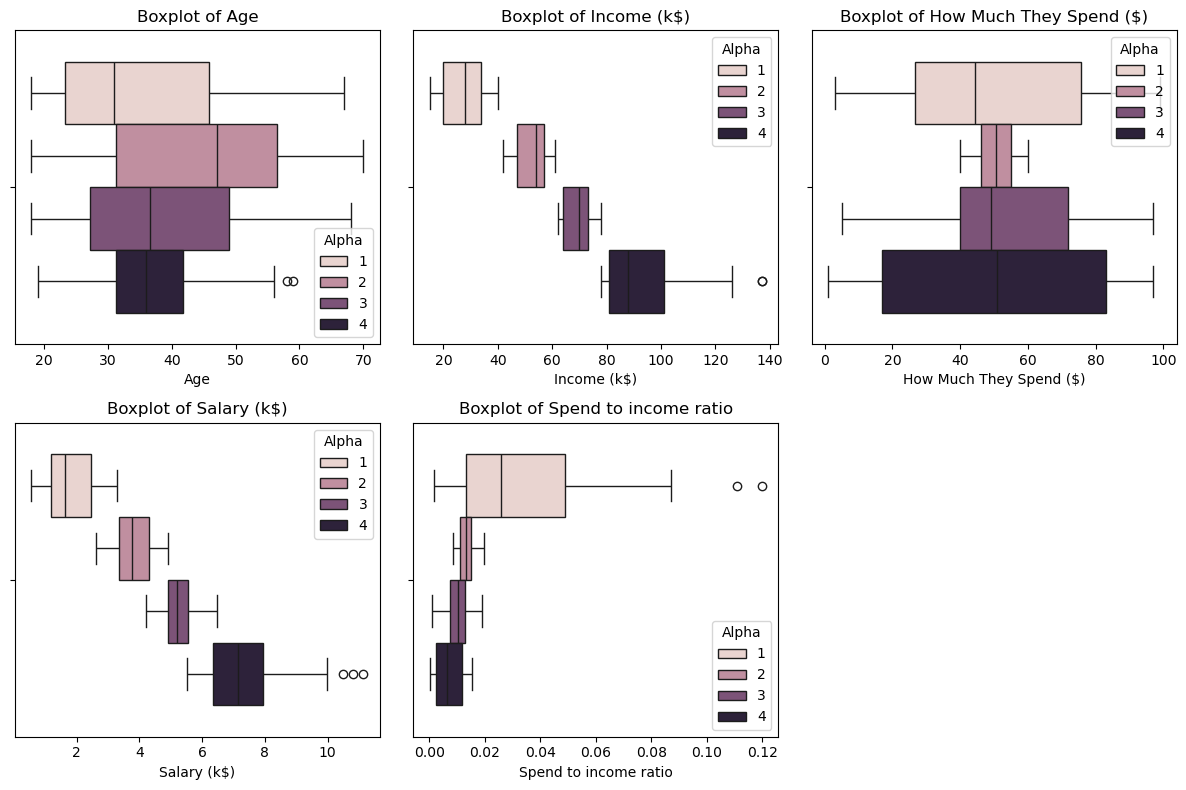

In [6]:
# Plotting the numerical features to visualize outliers
numerical_cols = ["Age", "Income (k$)", "How Much They Spend ($)", "Salary (k$)", "Spend to income ratio"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols):
  plt.subplot(2, 3, i + 1)
  sns.boxplot(data=customer, x=col, hue="Alpha")
  plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

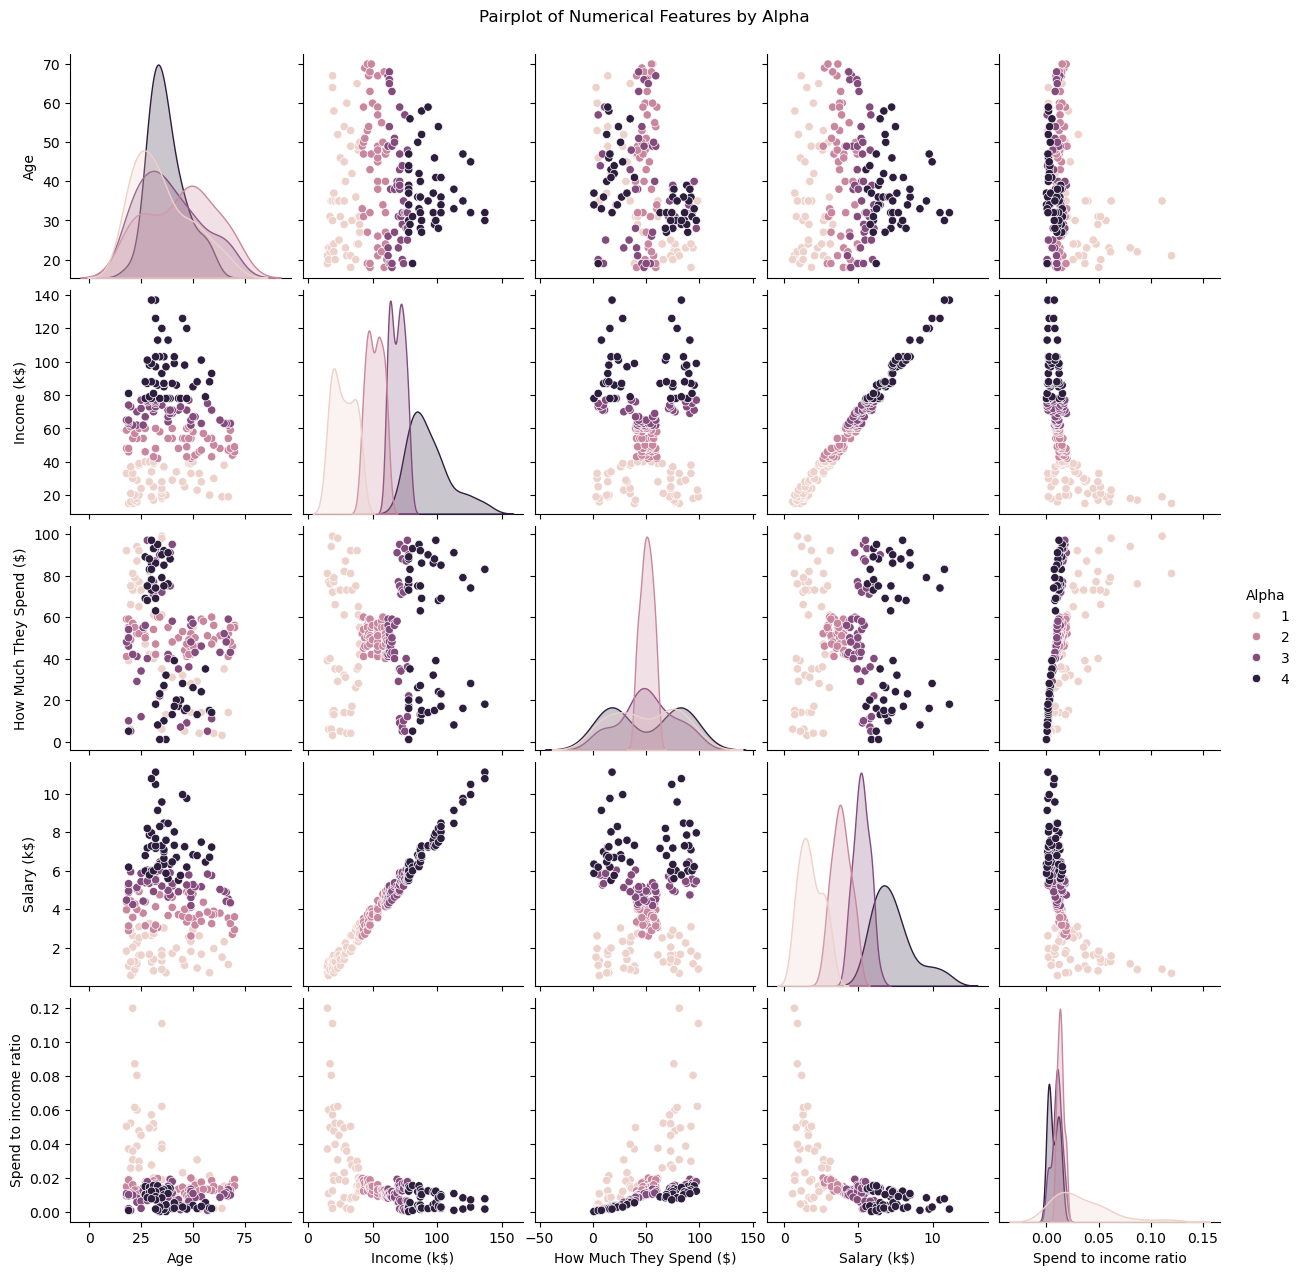

In [7]:
# pair plot to visualize relationships between numerical features
g = sns.pairplot(customer, hue='Alpha', vars=numerical_cols)
g.figure.suptitle('Pairplot of Numerical Features by Alpha', y=1.02)
plt.show()

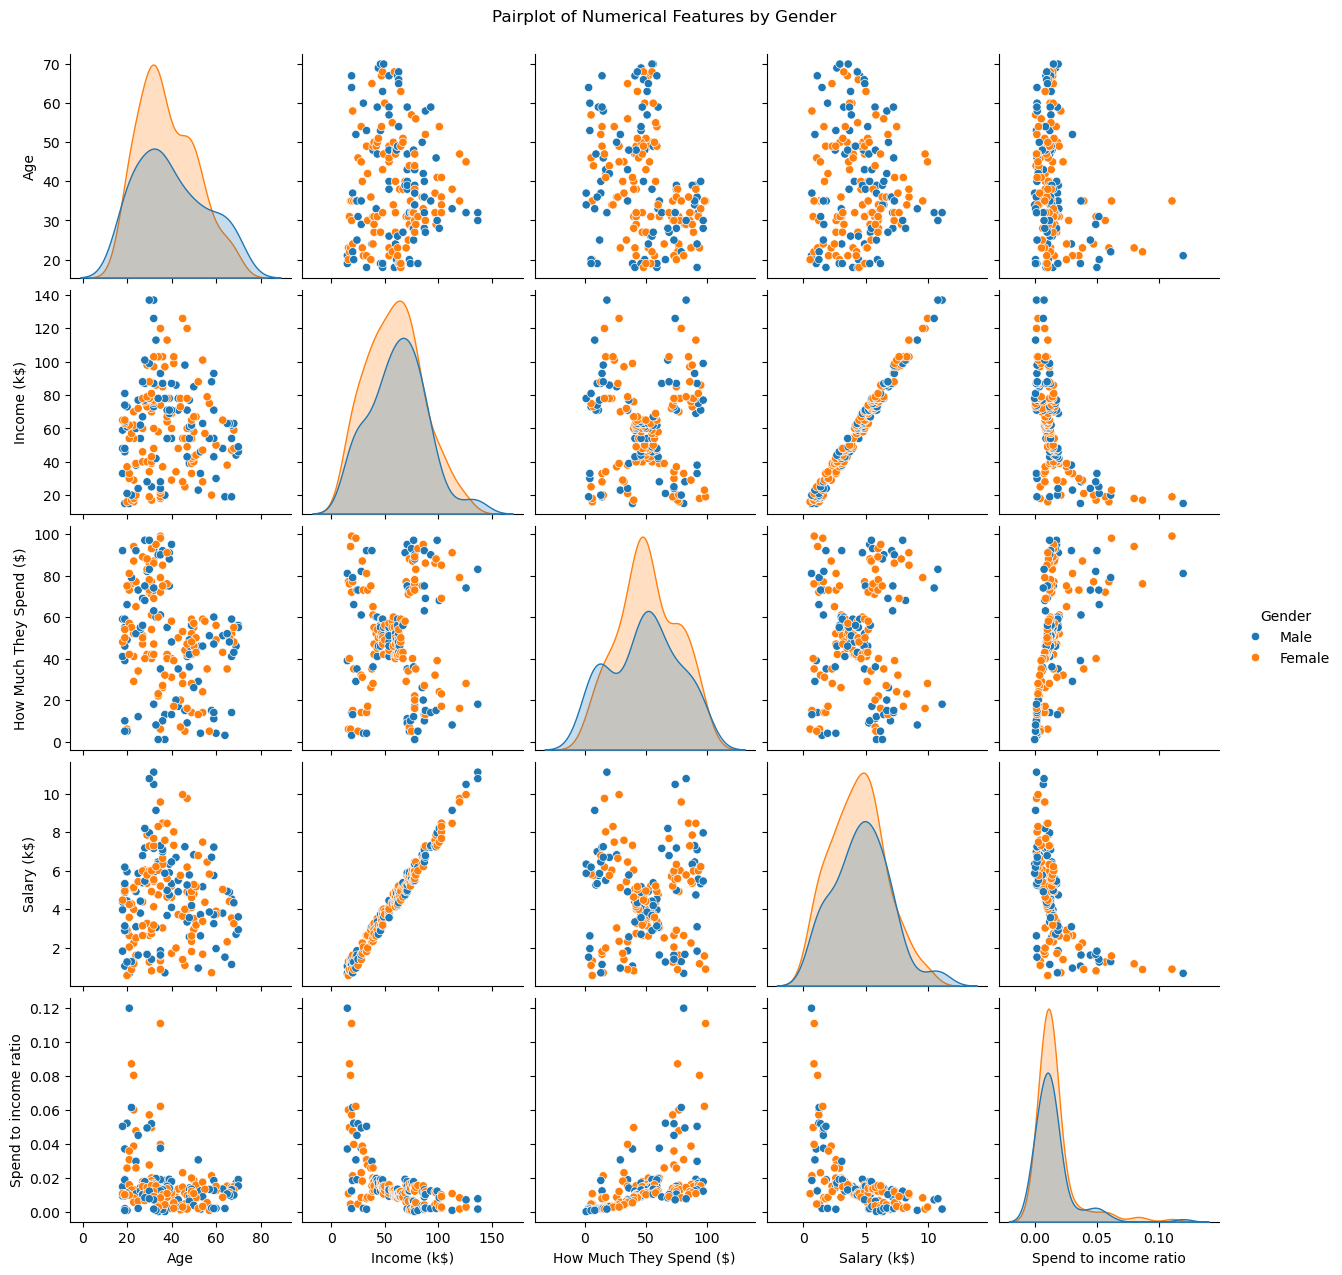

In [8]:
# pair plot to visualize relationships between numerical features
g = sns.pairplot(customer, hue='Gender', vars=numerical_cols)
g.figure.suptitle('Pairplot of Numerical Features by Gender', y=1.02)
plt.show()

# Data transformation

Transform the numerical features using StandardScaler to have 0 means and 1 variance

In [9]:
# Data Preprocessing
# copy the original DataFrame to avoid modifying it directly
customer_transform = customer.copy()
# remove unnecessary columns  
customer_transform.drop(columns=['CustomerID'], inplace=True)

# Transform numerical columns with StandardScaler
scaler = StandardScaler()
numerical_cols = customer_transform.select_dtypes(include=['int64', 'float64']).columns
customer_transform[numerical_cols] = scaler.fit_transform(customer_transform[numerical_cols]) 
# Transform categorical columns with one-hot encoding
categorical_cols = ["Gender"]
customer_transform = pd.get_dummies(customer_transform, columns=categorical_cols, drop_first=True, dtype=int)

print(customer_transform.head())
print("\nDescriptive statistics of transformed data:")
print(customer_transform.describe())


        Age  Income (k$)  How Much They Spend ($)  Salary (k$)  \
0 -1.424569    -1.738999                -0.434801    -1.576835   
1 -1.281035    -1.738999                 1.195704    -1.748301   
2 -1.352802    -1.700830                -1.715913    -1.799901   
3 -1.137502    -1.700830                 1.040418    -1.472983   
4 -0.563369    -1.662660                -0.395980    -1.689234   

   Spend to income ratio     Alpha  Gender_Male  
0               1.240737 -1.341641            1  
1               6.098642 -1.341641            1  
2              -0.301771 -1.341641            0  
3               2.588929 -1.341641            0  
4               1.980859 -1.341641            0  

Descriptive statistics of transformed data:
                Age   Income (k$)  How Much They Spend ($)   Salary (k$)  \
count  2.000000e+02  2.000000e+02             2.000000e+02  2.000000e+02   
mean  -1.021405e-16 -2.131628e-16            -1.465494e-16 -7.105427e-17   
std    1.002509e+00  1.002509e

# choosing n_clusters using the elbow method

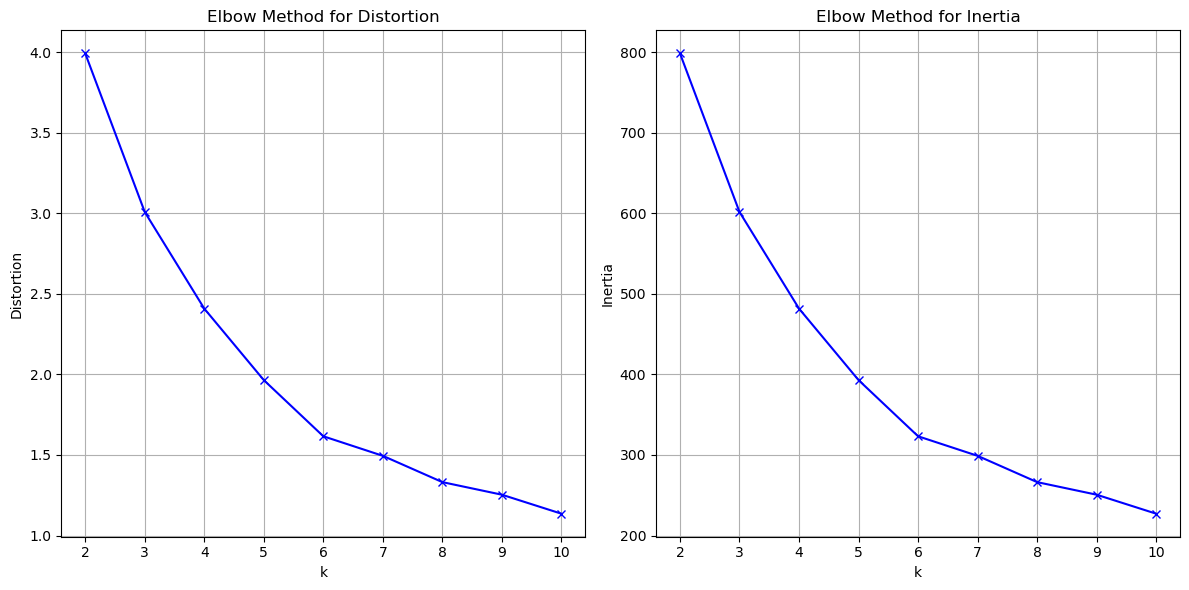

Distortion values:
2 : 3.993974002250099
3 : 3.0090533557254746
4 : 2.409006059069258
5 : 1.9649443127869315
6 : 1.6161449638524197
7 : 1.49473200100746
8 : 1.3314350833592774
9 : 1.253302051426047
10 : 1.1353551859504842

Inertia values:
2 : 798.7948004500198
3 : 601.810671145095
4 : 481.80121181385147
5 : 392.98886255738626
6 : 323.2289927704836
7 : 298.9464002014919
8 : 266.28701667185555
9 : 250.6604102852094
10 : 227.0710371900968


In [10]:
# Using Elbow method to choose n_cluster

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(2, 11)

for k in K:
  kmeanModel = KMeans(n_clusters=k, random_state=42).fit(customer_transform)
  distortions.append(
    sum(np.min(cdist(customer_transform, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / customer_transform.shape[0]
  )
  inertias.append(kmeanModel.inertia_)
  mapping1[k] = distortions[-1]
  mapping2[k] = inertias[-1]

# Plotting the elbow curve for distortions and inertias
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for Distortion')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Inertia')
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

print("Distortion values:")
for key, val in mapping1.items():
  print(f'{key} : {val}')

print()
print("Inertia values:")
for key, val in mapping2.items():
  print(f'{key} : {val}')

# choosing n_clusters using silhouette scores

Silhouette Score Analysis:
----------------------------------------
k= 2: Silhouette Score = 0.3088
k= 3: Silhouette Score = 0.3089
k= 4: Silhouette Score = 0.3335
k= 5: Silhouette Score = 0.3274
k= 6: Silhouette Score = 0.3505
k= 7: Silhouette Score = 0.3274
k= 8: Silhouette Score = 0.3221
k= 9: Silhouette Score = 0.2974
k=10: Silhouette Score = 0.2820

Optimal k based on Silhouette Score: 6 (Score: 0.3505)


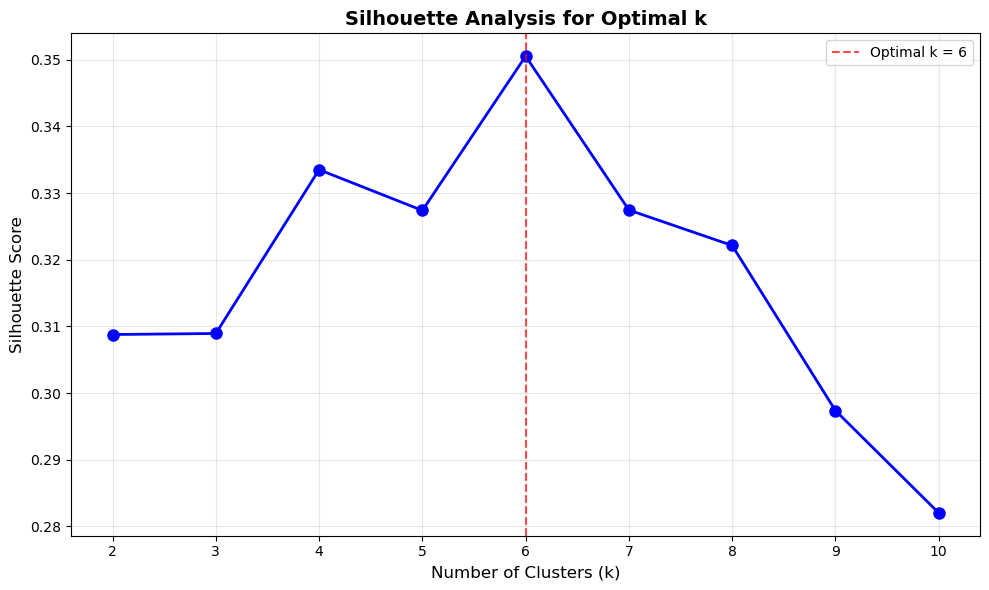

In [11]:
# Calculate silhouette scores for different k values
silhouette_scores = []
k_silhouette_mapping = {}

print("Silhouette Score Analysis:")
print("-" * 40)

for k in K:
  kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
  cluster_labels = kmeans.fit_predict(customer_transform)
  silhouette_avg = silhouette_score(customer_transform, cluster_labels, metric="euclidean")
  silhouette_scores.append(silhouette_avg)
  k_silhouette_mapping[k] = silhouette_avg
  print(f"k={k:2d}: Silhouette Score = {silhouette_avg:.4f}")

# Find optimal k based on silhouette score
if k_silhouette_mapping:  # Check if dictionary is not empty
  optimal_k = max(k_silhouette_mapping, key=k_silhouette_mapping.get)
  print(f"\nOptimal k based on Silhouette Score: {optimal_k} (Score: {k_silhouette_mapping[optimal_k]:.4f})")
else:
  print("No clusters evaluated!")
  optimal_k = 2

# Plotting silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.title('Silhouette Analysis for Optimal k', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(2, 11))

# Highlight optimal k
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, 
            label=f'Optimal k = {optimal_k}')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# Anomaly

In [12]:
def detect_anomalies(X: np.ndarray, kmeans: KMeans, n_anomalies: int = 5) -> tuple:
  """
  Detect anomalies based on distance to the closest centroid.
  
  Parameters
  ----------
  X : np.ndarray
    Feature matrix of shape (n_samples, n_features)
  kmeans : KMeans
    Fitted K-means model
  n_anomalies : int, optional
    Number of anomalies to detect, by default 5
  
  Returns
  -------
  tuple
    - anomaly_indices: Indices of detected anomalies
    - X_without_anomalies: Data with anomalies removed
    - anomaly_data: Data points identified as anomalies
    - distances: Distances from each point to nearest centroid
    
  Raises
  ------
  ValueError
    If n_anomalies is greater than the number of samples
  """
  # Validate input parameters
  if n_anomalies > X.shape[0]:
    raise ValueError(
      f"n_anomalies ({n_anomalies}) cannot be greater than "
      f"number of samples ({X.shape[0]})"
    )
  
  # Calculate distances to closest centroid for each point
  distances = kmeans.transform(X).min(axis=1)
  
  # Identify points with largest distances (potential anomalies)
  anomaly_indices = np.argsort(distances)[::-1][:n_anomalies]
  
  # Create dataset without anomalies
  X_without_anomalies = np.delete(X, anomaly_indices, axis=0)
  
  # Extract anomalous data points
  anomaly_data = X[anomaly_indices, :]
  
  # Display detection statistics
  print("Anomaly Detection Statistics:")
  print("-" * 30)
  print(f"Total samples: {X.shape[0]}")
  print(f"Anomalies detected: {n_anomalies}")
  print(f"Mean distance to centroid: {distances.mean():.3f}")
  print(f"Std distance to centroid: {distances.std():.3f}")
  print(f"Max anomaly distance: {distances[anomaly_indices[0]]:.3f}")
  print(f"Min anomaly distance: {distances[anomaly_indices[-1]]:.3f}")
  
  return anomaly_indices, X_without_anomalies, anomaly_data, distances

# Detect anomalies


KMeans(n_clusters=6)
Anomaly Detection Statistics:
------------------------------
Total samples: 200
Anomalies detected: 5
Mean distance to centroid: 1.177
Std distance to centroid: 0.480
Max anomaly distance: 4.019
Min anomaly distance: 2.420


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


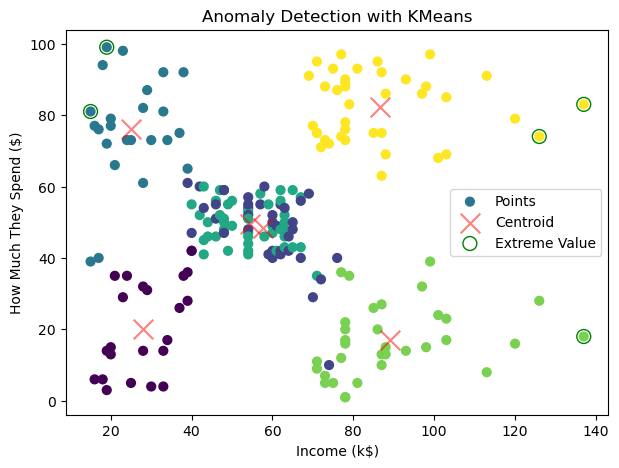

Anomalies from the original data:
     CustomerID  Gender  Age  Income (k$)  How Much They Spend ($)  \
1             2    Male   21           15                       81   
11           12  Female   35           19                       99   
198         199    Male   32          137                       18   
199         200    Male   30          137                       83   
197         198    Male   32          126                       74   

     Salary (k$)  Spend to income ratio  Alpha  
1       0.676210               0.119785      1  
11      0.893771               0.110767      1  
198    11.133367               0.001617      4  
199    10.796760               0.007687      4  
197    10.497569               0.007049      4  


In [13]:
# Anomaly Detection using KMeans
cluster = 6

kmeans = KMeans(n_clusters=cluster)
kmeans.fit(customer_transform)
print(kmeans)
y_kmeans = kmeans.predict(customer_transform)
centers = kmeans.cluster_centers_
centers_inv = scaler.inverse_transform(centers[:,:-1]) 
anomaly_indices, X_without_anomalies, anomaly_data, distances = detect_anomalies(customer_transform.values, kmeans, n_anomalies= 5)

# Visualize the results
# argsort returns an array of indexes which will sort the array in ascending order
# so we reverse it via [::-1] and take the top five with [:5]
distances = kmeans.transform(customer_transform)
sorted_idx = anomaly_indices
# Now let's see which are the top n_anomalies points furthest away
f, ax = plt.subplots(figsize=(7, 5))
ax.set_title("Anomaly Detection with KMeans")
ax.scatter(customer["Income (k$)"], customer["How Much They Spend ($)"], c=y_kmeans, s=40, cmap='viridis',label='Points')
ax.scatter(centers_inv[:, 1], centers_inv[:, 2], label='Centroid', color='r',  marker='x',s=200, alpha=0.5)
ax.scatter(customer.iloc[sorted_idx]['Income (k$)'], 
           customer.iloc[sorted_idx]["How Much They Spend ($)"], 
           label='Extreme Value', edgecolors='g', facecolors='none', s=100)
ax.legend(loc='best')
plt.xlabel("Income (k$)")
plt.ylabel("How Much They Spend ($)")
plt.show()
# It's easy to remove these points if we like:
# new_Customer = np.delete(customer_transform, sorted_idx, axis=0)
new_Customer_transformed = customer_transform.drop(customer_transform.index[sorted_idx])
new_Customer = customer.drop(customer.index[sorted_idx])
# Or to extract the anomalies
anomaly = customer.iloc[sorted_idx]
anomaly_transformed = customer_transform.iloc[sorted_idx]
print("Anomalies from the original data:")
print(anomaly)

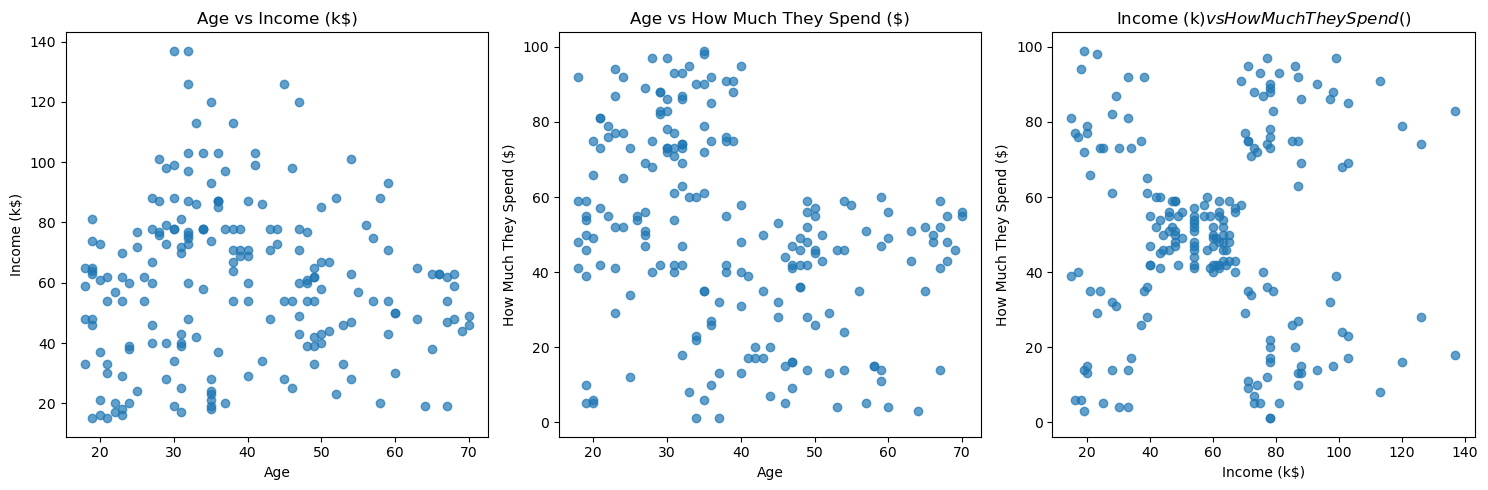

In [14]:
def plot_feature_pairs(df, feature_pairs, max_cols=3, figsize=(15, 5)):
  """
  Plots scatter plots for a list of feature pairs in subplots.

  Parameters:
  - df: pandas DataFrame containing the data.
  - feature_pairs: list of tuples, each tuple contains two feature names (x, y).
  - max_cols: maximum number of columns in the subplot grid.
  - figsize: size of the entire figure.
  """
  n_pairs = len(feature_pairs)
  n_cols = min(max_cols, n_pairs)
  n_rows = (n_pairs + n_cols - 1) // n_cols

  fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
  axes = np.array(axes).reshape(-1)  # Flatten in case of single row/col

  for idx, (x, y) in enumerate(feature_pairs):
    ax = axes[idx]
    ax.scatter(df[x], df[y], alpha=0.7)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'{x} vs {y}')

  # Hide unused subplots
  for j in range(idx + 1, n_rows * n_cols):
    axes[j].set_visible(False)

  plt.tight_layout()
  plt.show()

# Example usage:
feature_pairs = [
  ("Age", "Income (k$)"),
  ("Age", "How Much They Spend ($)"),
  ("Income (k$)", "How Much They Spend ($)")
]
plot_feature_pairs(customer, feature_pairs)

# PCA

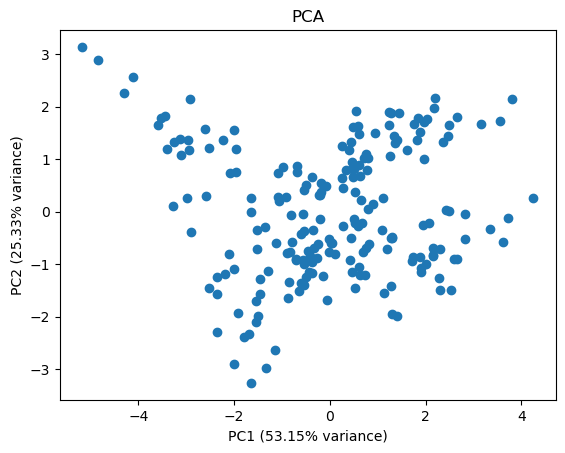

In [15]:
# Apply PCA with two components (for 2D visualization)
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(customer_transform)
# Plot the results
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1])
plt.title('PCA')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.show()

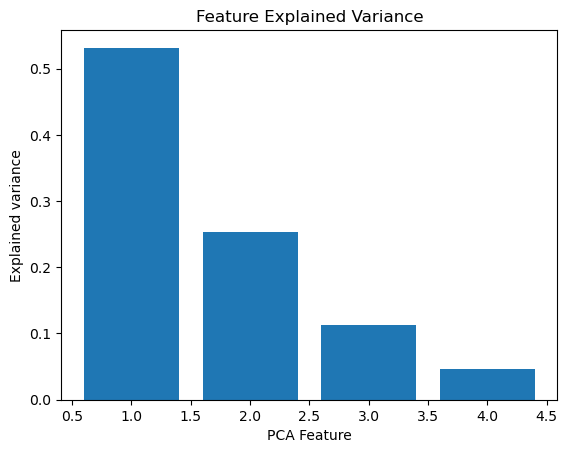

In [16]:
# Analyzing explained variance for customer dataset features
pca = PCA(n_components=4)
# Fit and transform data
pca_features = pca.fit_transform(customer_transform)
# Bar plot of explained_variance_ratio_
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),
pca.explained_variance_ratio_)
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

In [24]:
from mpl_toolkits import mplot3d

# Magic line to make your 3-d graph pop out,
# and you can interactively rotate it.
%matplotlib tk

# Visualize PCA-based clustering
def visualize_pca_clustering(data, n_components=3, n_clusters=6, n_anomalies = 5):
  # Apply PCA
  pca = PCA(n_components=n_components)
  X_pca = pca.fit_transform(data)

  # Apply KMeans
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  clusters = kmeans.fit_predict(X_pca)
  distances = kmeans.transform(X_pca)

  anomaly_indices, X_without_anomalies, anomaly_data, distances = detect_anomalies(X_pca, kmeans, n_anomalies)

  if n_components == 2:
    # 2D visualization
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                c='red', marker='x', s=200, alpha=0.8, label='Centroids')
    plt.scatter(X_pca[anomaly_indices,0], X_pca[anomaly_indices, 1], 
                label='Extreme Value', edgecolors='g', facecolors='none', s=100)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(f'KMeans Clustering on PCA-reduced Data ({n_components}D)')
    plt.colorbar(scatter)
    plt.legend()
    plt.show()

  elif n_components == 3:
    # 3D visualization
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                         c=clusters, cmap='viridis', alpha=0.7)
    ax.scatter(kmeans.cluster_centers_[:, 0],
               kmeans.cluster_centers_[:, 1],
               kmeans.cluster_centers_[:, 2],
               c='red', marker='x', s=200, alpha=0.8)
    ax.scatter(X_pca[anomaly_indices,0], X_pca[anomaly_indices, 1], X_pca[anomaly_indices, 2],
                label='Extreme Value', edgecolors='g', facecolors='none', s=100)

    ax.set(xlabel = f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax.set(ylabel = f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax.set(zlabel = f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')
    ax.set_title(f'KMeans Clustering on PCA-reduced Data ({n_components}D)')
    plt.colorbar(scatter)
    plt.show()

  else:
    print(f"Visualization not supported for {n_components} components")
    print("Please use n_components=2 or n_components=3")
  return anomaly_indices


In [27]:
# Visualize different PCA dimensions
visualize_pca_clustering(customer_transform, n_components = 2, n_anomalies = 5)
anomaly_indices_3d = visualize_pca_clustering(customer_transform, n_components = 3, n_anomalies = 5)

Anomaly Detection Statistics:
------------------------------
Total samples: 200
Anomalies detected: 5
Mean distance to centroid: 0.851
Std distance to centroid: 0.408
Max anomaly distance: 2.244
Min anomaly distance: 1.889
Anomaly Detection Statistics:
------------------------------
Total samples: 200
Anomalies detected: 5
Mean distance to centroid: 0.950
Std distance to centroid: 0.460
Max anomaly distance: 2.843
Min anomaly distance: 2.066


In [28]:
customer.iloc[anomaly_indices_3d,:]

,CustomerID,Gender,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha
11,12,Female,35,19,99,0.893771,0.110767,1
1,2,Male,21,15,81,0.676210,0.119785,1
198,199,Male,32,137,18,11.133367,0.001617,4
199,200,Male,30,137,83,10.796760,0.007687,4
197,198,Male,32,126,74,10.497569,0.007049,4


In [30]:
anomaly_df = customer.iloc[anomaly_indices_3d,:]
anomaly_df

,CustomerID,Gender,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha
11,12,Female,35,19,99,0.893771,0.110767,1
1,2,Male,21,15,81,0.676210,0.119785,1
198,199,Male,32,137,18,11.133367,0.001617,4
199,200,Male,30,137,83,10.796760,0.007687,4
197,198,Male,32,126,74,10.497569,0.007049,4


In [29]:
customer.describe()

,CustomerID,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000
mean,100.500000,38.850000,60.560000,50.200000,4.538022,0.015816,2.50000
std,57.879185,13.969007,26.264721,25.823522,2.214437,0.017091,1.12084
min,1.000000,18.000000,15.000000,1.000000,0.562232,0.000157,1.00000
25%,50.750000,28.750000,41.500000,34.750000,2.963534,0.008362,1.75000
50%,100.500000,36.000000,61.500000,50.000000,4.577495,0.012212,2.50000
75%,150.250000,49.000000,78.000000,73.000000,5.905840,0.015903,3.25000
max,200.000000,70.000000,137.000000,99.000000,11.133367,0.119785,4.00000


In [23]:
# Compare clustering with and without PCA
def compare_clustering_performance(data, n_clusters=6):
  results = {}

  # Original data clustering
  kmeans_original = KMeans(n_clusters=n_clusters, random_state=42)
  clusters_original = kmeans_original.fit_predict(data)
  silhouette_original = silhouette_score(data, clusters_original)

  # PCA + clustering for different components
  for n_comp in [2, 3, 4, 5]:
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(data)

    kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
    clusters_pca = kmeans_pca.fit_predict(X_pca)
    silhouette_pca = silhouette_score(X_pca, clusters_pca)

    results[f'PCA_{n_comp}'] = {
      'silhouette': silhouette_pca,
      'explained_variance': pca.explained_variance_ratio_.sum(),
      'clusters': clusters_pca,
      'data': X_pca
    }

  results['Original'] = {
    'silhouette': silhouette_original,
    'explained_variance': 1.0,
    'clusters': clusters_original,
    'data': data
  }

  # Print comparison
  print("Clustering Performance Comparison:")
  print("-" * 50)
  for method, metrics in results.items():
    print(f"{method:12}: Silhouette = {metrics['silhouette']:.4f}, "
          f"Variance = {metrics['explained_variance']:.3f}")

  return results

performance_results = compare_clustering_performance(customer_transform)

Clustering Performance Comparison:
--------------------------------------------------
PCA_2       : Silhouette = 0.4056, Variance = 0.785
PCA_3       : Silhouette = 0.4229, Variance = 0.898
PCA_4       : Silhouette = 0.4087, Variance = 0.945
PCA_5       : Silhouette = 0.3683, Variance = 0.983
Original    : Silhouette = 0.3505, Variance = 1.000


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def compare_clustering_with_pipelines(data, n_clusters=6):
  results = {}

  # Pipeline 1: KMeans without PCA
  kmeans_pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
  ])

  # Fit and get clusters
  clusters_no_pca = kmeans_pipeline.fit_predict(data)
  silhouette_no_pca = silhouette_score(data, clusters_no_pca)

  results['No_PCA'] = {
    'pipeline': kmeans_pipeline,
    'silhouette': silhouette_no_pca,
    'explained_variance': 1.0,
    'clusters': clusters_no_pca,
    'n_components': data.shape[1]
  }

  # Pipeline 2-5: PCA + KMeans for different components
  for n_comp in [2, 3, 4, 5]:
    pca_kmeans_pipeline = Pipeline([
      ('pca', PCA(n_components=n_comp)),
      ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
    ])

    # Fit and get clusters
    clusters_pca = pca_kmeans_pipeline.fit_predict(data)

    # Get PCA-transformed data for silhouette calculation
    X_pca = pca_kmeans_pipeline.named_steps['pca'].transform(data)
    silhouette_pca = silhouette_score(X_pca, clusters_pca)

    # Get explained variance
    explained_var = pca_kmeans_pipeline.named_steps['pca'].explained_variance_ratio_.sum()

    results[f'PCA_{n_comp}'] = {
      'pipeline': pca_kmeans_pipeline,
      'silhouette': silhouette_pca,
      'explained_variance': explained_var,
      'clusters': clusters_pca,
      'n_components': n_comp
    }

  return results

# Run the comparison
pipeline_results = compare_clustering_with_pipelines(customer_transform)

# Print results
print("Pipeline-Based Clustering Comparison:")
print("=" * 60)
for method, metrics in pipeline_results.items():
  print(f"{method:12}: Silhouette = {metrics['silhouette']:.4f}, "
        f"Variance = {metrics['explained_variance']:.3f}, "
        f"Components = {metrics['n_components']}")

Pipeline-Based Clustering Comparison:
No_PCA      : Silhouette = 0.3505, Variance = 1.000, Components = 7
PCA_2       : Silhouette = 0.4056, Variance = 0.785, Components = 2
PCA_3       : Silhouette = 0.4229, Variance = 0.898, Components = 3
PCA_4       : Silhouette = 0.4087, Variance = 0.945, Components = 4
PCA_5       : Silhouette = 0.3683, Variance = 0.983, Components = 5
